This example demonstrates multi-band single-shot EPI reconstruction.

Author:
    
* Zhengguo Tan <zhengguo.tan@gmail.com>

In [65]:
import h5py
import os
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

from deepdwi import fourier, util
from deepdwi.models import mri

DIR = os.getcwd()
print(DIR)

/home/zhengguo/Softwares/DeepDWI/examples


### load data from Zenodo

In [64]:
files_list = ['1.7x1.7x4.0mm_R2x3_kdat.h5',
              '1.7x1.7x4.0mm_R2x3_refs.h5']

for f in files_list:
    if os.path.exists('../data/' + f):
        print(f'the file {f} exists.')
    else:
        os.system('wget -P ../data/ -q https://zenodo.org/records/10474402/files/' + f)

the file 1.7x1.7x4.0mm_R2x3_kdat.h5 exists.
the file 1.7x1.7x4.0mm_R2x3_refs.h5 exists.


In [5]:
# k-space data
f = h5py.File('../data/1.7x1.7x4.0mm_R2x3_kdat.h5', 'r')
kdat = f['kdat'][:]
MB = f['MB'][()]
N_Accel_PE = f['Accel_PE'][()]
f.close()

kdat_prep = np.squeeze(kdat)
kdat_prep = np.swapaxes(kdat_prep, -2, -3)

N_diff, N_coil, N_y, N_x = kdat_prep.shape

kdat_prep = kdat_prep[:, None, :, None, :, :]  # 6 dim

print('kdat shape: ', kdat_prep.shape)

# coil sensitivity maps
f = h5py.File('../data/1.7x1.7x4.0mm_R2x3_refs.h5', 'r')
refs = f['refs'][:]
f.close()

print('refs shape: ', refs.shape)

N_slice =refs.shape[-3]

kdat shape:  (12, 1, 16, 1, 130, 130)
refs shape:  (16, 3, 130, 130)


### device

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device: ', device)

device:  cuda


### estimate coil sensitivity maps using EPIRiT

In [10]:
from sigpy.mri import app
import sigpy as sp

mps = []
for s in range(N_slice):
    print('  ' + str(s).zfill(3))

    c = app.EspiritCalib(refs[:, s, :, :], thresh=0.03,
                        crop=0.95,
                        device=sp.cpu_device,
                        show_pbar=False).run()
    mps.append(sp.to_device(c))

mps = np.array(mps)
mps = mps[[0, 2, 1], ...]  # slice reordering
mps = np.swapaxes(mps, 0, 1)

print('> mps shape: ', mps.shape)

  000
  001
  002
> mps shape:  (16, 3, 130, 130)


### calculate multi-band phase shift

In [11]:
from sigpy.mri import sms

yshift = []
for b in range(MB):
    yshift.append(b / N_Accel_PE)

sms_phase = sms.get_sms_phase_shift([MB, N_y, N_x], MB=MB,
                                    yshift=yshift)

 > sms: yshift  [0.0, 0.5, 1.0]


### define Sense as nn.Module

In [59]:
# reconstruct the b0 image
y = kdat_prep[[0], ...]

y_tensor = torch.from_numpy(y).to(device)
c_tensor = torch.from_numpy(mps).to(device)

sms_phase_tensor = torch.from_numpy(sms_phase).to(device).type(y_tensor.dtype)

S = mri.Sense(c_tensor, y_tensor, phase_slice=sms_phase_tensor).to(device)

print('S ishape: ', S.ishape)
print('S oshape: ', S.oshape)

S ishape:  [1, 1, 1, 3, 130, 130]
S oshape:  torch.Size([1, 1, 16, 1, 130, 130])


### solve the inverse problem

In [60]:
x_torch = torch.zeros(S.ishape, dtype=y_tensor.dtype,
                      requires_grad=True, device=device)

loss = nn.MSELoss(reduction='sum')
optimizer = optim.Adam([x_torch], lr=0.00005)

for epoch in range(100):
    fwd = S(x_torch)
    res = loss(torch.view_as_real(y_tensor), torch.view_as_real(fwd))

    optimizer.zero_grad()
    res.backward()
    optimizer.step()

    print('> epoch %3d loss %15.6f'%(epoch, res.item()))

> epoch   0 loss        0.000658
> epoch   1 loss        0.000302
> epoch   2 loss        0.000147
> epoch   3 loss        0.000120
> epoch   4 loss        0.000136
> epoch   5 loss        0.000146
> epoch   6 loss        0.000137
> epoch   7 loss        0.000116
> epoch   8 loss        0.000091
> epoch   9 loss        0.000072
> epoch  10 loss        0.000061
> epoch  11 loss        0.000055
> epoch  12 loss        0.000053
> epoch  13 loss        0.000050
> epoch  14 loss        0.000047
> epoch  15 loss        0.000042
> epoch  16 loss        0.000037
> epoch  17 loss        0.000033
> epoch  18 loss        0.000030
> epoch  19 loss        0.000028
> epoch  20 loss        0.000026
> epoch  21 loss        0.000024
> epoch  22 loss        0.000022
> epoch  23 loss        0.000020
> epoch  24 loss        0.000018
> epoch  25 loss        0.000016
> epoch  26 loss        0.000014
> epoch  27 loss        0.000013
> epoch  28 loss        0.000012
> epoch  29 loss        0.000012
> epoch  3

(1, 1, 16, 1, 130, 130)


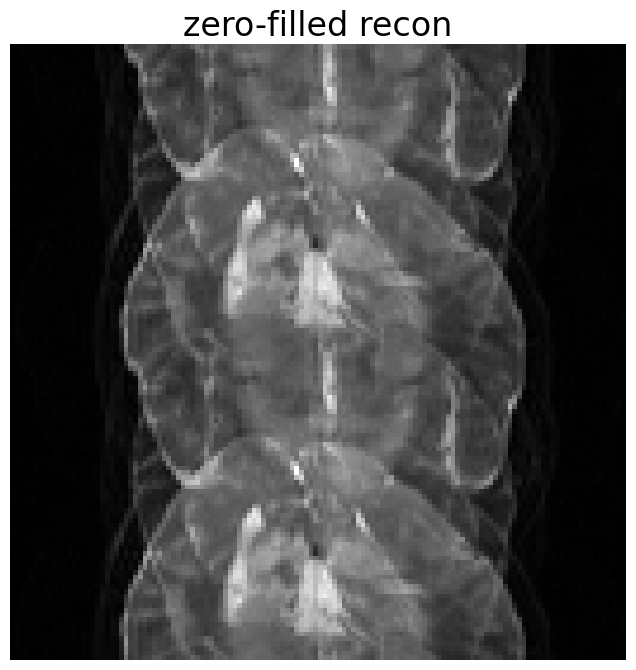

In [61]:
mask = np.sqrt(np.sum(abs(y)**2, axis=-4)) > 0

print(y.shape)

x_zf = util.rss(fourier.ifft(y_tensor, dim=(-2, -1)), dim=-4)
x_zf = np.squeeze(x_zf).cpu().detach().numpy()

f, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(np.squeeze(abs(x_zf)), cmap='gray')
ax.set_title('zero-filled recon', fontsize=24)
ax.set_axis_off()

plt.show()

(3, 130, 130)


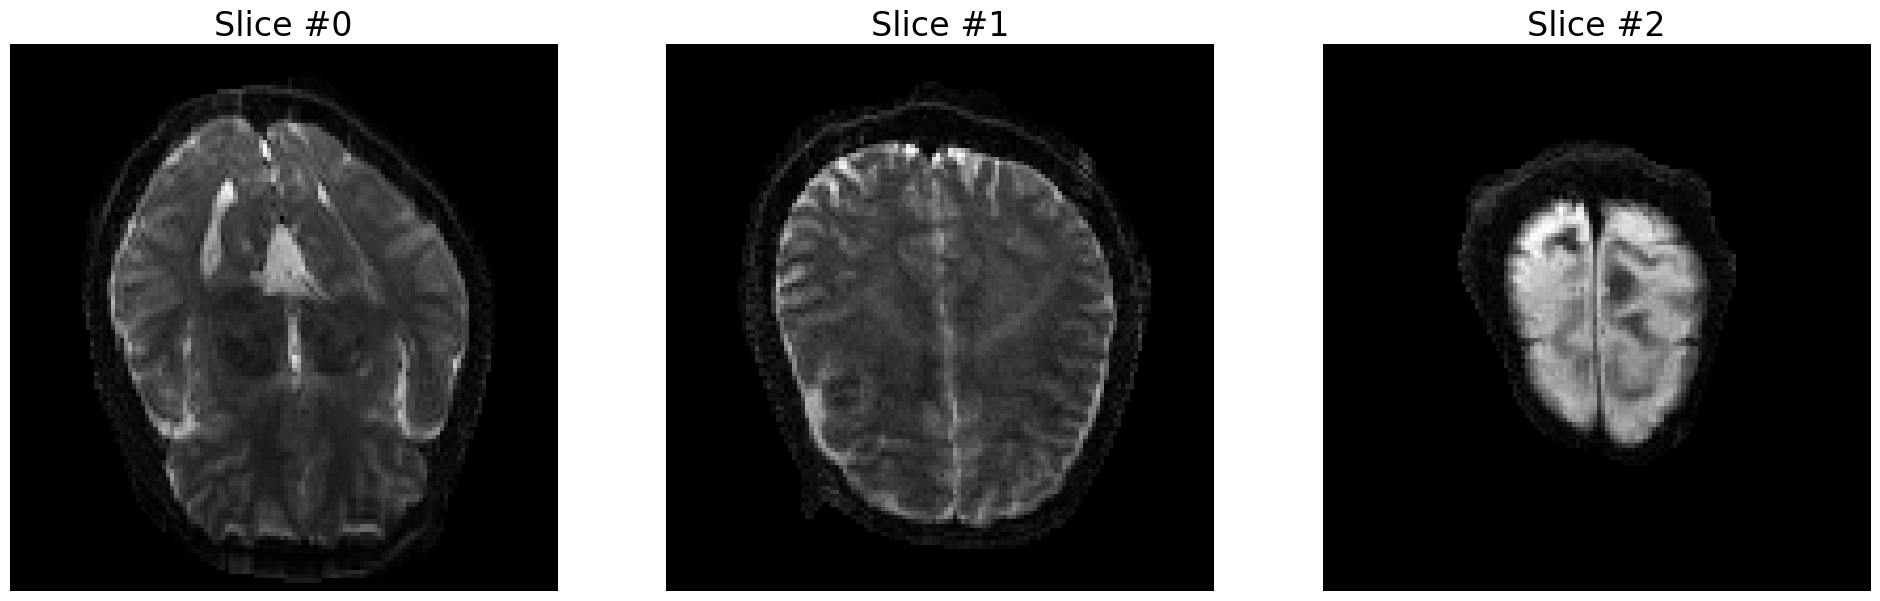

In [62]:
x_arr = x_torch.cpu().detach().numpy().squeeze()
print(x_arr.shape)

fig, ax = plt.subplots(1, 3, figsize=(24, 8))

for s in range(N_slice):
    ax[s].imshow(abs(x_arr[s]), cmap='gray')
    ax[s].set_axis_off()
    ax[s].set_title('Slice #' + str(s), fontsize=24)

plt.show()